In [ ]:
#----------Running the code-------------#
""" 
  Just run the script in the folder containing 'data.pickle' and 'data.csv file' 
  
"""

#---------------OVERVIEW----------------#
"""
*  Input data is padded with a special value to make all the sequnces of equal
   length and an additional masking layer is used to mask these special value
   during training.
   
*  Since the dataset is imbalanced various techniques like stratification,class
   weighting and precision-recall curves are also used.
   
*  Model: Stacked LSTM layers are used for encoding the time series and then the 
   encoding is passed through dense layers for classification.
               
*  Hyperparameter tuning is performed to find the best size of the network.
   
"""

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Masking, BatchNormalization, Activation
import keras_tuner as kt

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

<font size = 4><b>Helper Functions

In [4]:
def plot_loss(history):
    
    """
    Using the history logs of the trained model this function plots the training 
    loss and validation loss on each epoch, using a log scale on y-axis to show 
    the wide range of values.
    
    """
    
    # Training Loss vs Epoch
    plt.plot(history.epoch, history.history['loss'], label='Train ')
    # Validation Loss vs Epoch
    plt.plot(history.epoch, history.history['val_loss'], label='Val ', 
             linestyle="--")
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()

In [39]:
def plot_metrics(history):
    """
    Using the history logs and metrics of the trained model this function plots 
    4 subplots of precision, recall, loss and area under precision-recall curve 
    for the training and validation data on each epoch.
    
    """
    
    metrics = ['loss', 'prc', 'precision', 'recall']

    for n, metric in enumerate(metrics):

      plt.subplot(2,2,n+1)
    
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], 
               linestyle="--", label='Val')
    
      plt.xlabel('Epoch')
      plt.ylabel(metric)
    
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      else:
        plt.ylim([0,1])

      plt.legend()

In [6]:
def plot_cm(true_labels, predictions, p=0.5):
    """
    Using the inbuilt function of confusion_matrix from sklearn this function 
    plots a confusion  matrix with a particular threshold(p) with default value 
    0.5.
    
    """
    # Confusion matrix 
    cm = confusion_matrix(true_labels, predictions > p)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.legend()

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total : ', np.sum(cm[1]))

In [8]:
def plot_prc(name, true_labels, predictions, **kwargs):
    """
    Using the inbuilt function of precision_recall_curve from sklearn this 
    function plots a PR curve
    
    """
    precision, recall, _ = sklearn.metrics.precision_recall_curve(true_labels,
                                                                  predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.set_aspect('equal')

In [13]:
def visualize_event(data, e):
    """
    This function visualizes all the features across timesteps in the data 
    for a particular event e.
    
    """
    
    fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
    idx = 0 
    for i in range(9):
        
        ax = axes.flatten()[idx]
        ax.plot(range(len(data[e][:,i])), data[e][:,i], linewidth=1)
        idx += 1

        ax.set_xlabel('Timesteps')
        ax.set_ylabel("Feature_" + str(i))
        
    plt.tight_layout() 

<font size = 3> <b>Building model

In [26]:
def hyper_model(hp):
    """
    This function builds a model with four hyperparameters(lstm_units, 
    dense1_units, dense2_units and learning_rate). This function is 
    passed to a keras hypermeter tuner to select a best hyperparameter 
    combination. 
    
    """
     
    model = keras.Sequential()
    
    # Masks a sequence by using a mask_value to skip timesteps which were padded 
    model.add(Masking(mask_value=special_value, 
                      input_shape=(max_seq_len, dimension)))
    
    # Tune the number of units in the LSTM layer
    # Choose an optimal value between 128-256
    lstm_units = hp.Int('lstm_units', min_value=128, max_value=256, step=128)
    model.add(LSTM(lstm_units, return_sequences = True))
    model.add(LSTM(lstm_units))
    
    # Tune the number of units in the first dense layer
    # Choose an optimal value between 256-512
    dense1_units = hp.Int('Dense_1', min_value=256, max_value=512, step=256)
    model.add(Dense(dense1_units))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    # Tune the number of units in the second dense layer
    # Choose an optimal value between 64-128
    dense2_units = hp.Int('Dense_2', min_value=64, max_value=128, step=64)
    model.add(Dense(dense2_units))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    
    model.compile(optimizer=keras.optimizers.Adam(
                  learning_rate=hp_learning_rate), 
                  loss=keras.losses.BinaryCrossentropy(), 
                  metrics=METRICS)


    return model

<font size = 3><b>Load Data


In [15]:
# Load data.pickle as raw_data
filename = 'data.pickle'
infile = open(filename,'rb')
raw_data = pickle.load(infile)
infile.close()

# Load data.csv as dataframe
df = pd.read_csv('data.csv')


<font size = 3> <b> Check the class distribution

Number of each output label are {0: 1775, 1: 225}


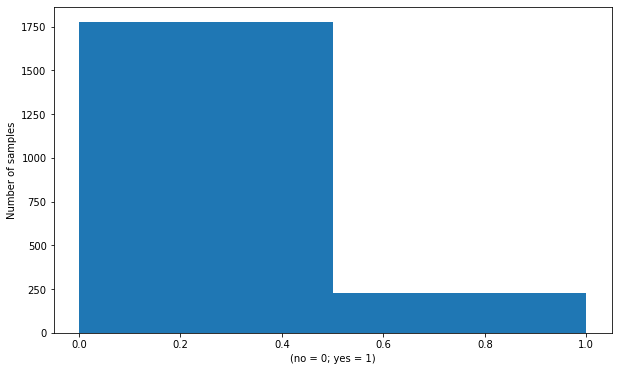

In [16]:
# output label
y = np.array(df['selected_event']) 

# count number of each class in the dataset
unique, counts = np.unique(y, return_counts=True)
print(f'Number of each output label are {dict(zip(unique, counts))}')

# plot the histogram for each class
plt.rcParams["figure.figsize"] = (10,6)
plt.hist(y, bins=2, density=False)
plt.ylabel('Number of samples')
plt.xlabel('(no = 0; yes = 1)')
plt.show()

<font size=3><b>Visualizes all the features across timesteps for a particular event

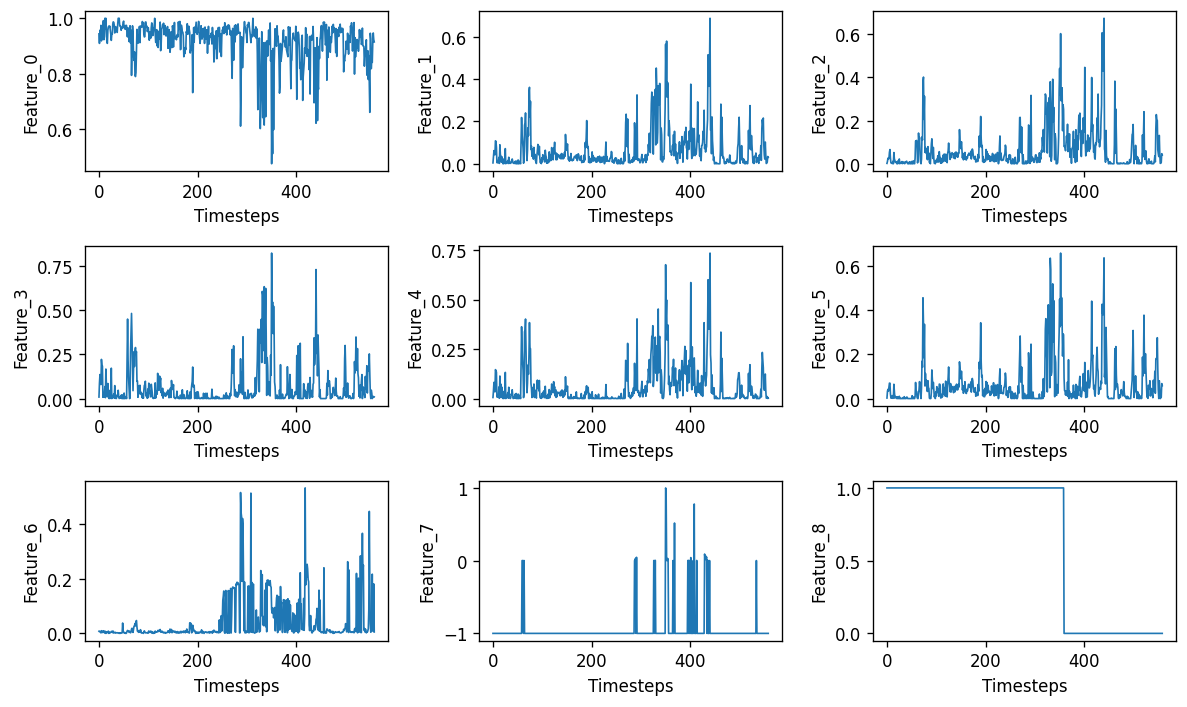

In [18]:
data = np.array(raw_data, dtype=object)

event = 100 #event to be visulaized
visualize_event(data, event)

<font size = 3><b>Pre-process the Data


In [19]:
# Padding the data with special_value(which will be masked later in LSTM layers)
# to make all the sequences all equal length.
max_seq_len = df['X_length'].max()
special_value = -10.0

# Value 2000 and 10 are hard coded. These are number of events and feature size
# respectively.
X = np.full((2000,max_seq_len,10), special_value, dtype=float)

for i in range(data.size):
    tmp = data[i].shape
    X[i,:tmp[0],:] = data[i]

# Check for missing anf inf vlaues
X = np.nan_to_num(X, copy=True, nan=0.0, posinf=None, neginf=None)

<font size = 3><b>Calculating class weights

In [20]:
# Since the data considered here is imbalanced, the weighted loss function is 
# used where minority class is penalized more according to the class weights. 
# This block calculates the class_weight which will passed to the model's loss
# function. 

total = counts[0] + counts[1]
weight_for_0 = (1 / counts[0]) * (total / 2.0)
weight_for_1 = (1 / counts[1]) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.44


<font size = 3><b>Train-Validation-Test split

In [21]:
# Split the dataset into train, validation and test set. Using stratify to make
# the split balanced with both classes.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  stratify = y_train)

<font size = 3><b>Define Parameters

In [22]:
# All the metrics which will be monitored during training.
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [23]:
# Parameters 
dimension = 10
verbosity = 1
EPOCHS = 200
BATCH_SIZE = 256 

# Callbacks used during training
# Validation precision-recall curve is monitored instead of accuracy since 
# the data is imbalanced
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', 
                                                  verbose=1, 
                                                  patience=10, mode='max')

# Callback for saving the best model
chk = tf.keras.callbacks.ModelCheckpoint('best_model',
                                         monitor='val_prc', 
                                         save_best_only=True, 
                                         mode='max', verbose=1)


<font size=3><b>Hyperparameter Tuning using Baysian Optimization
    

In [27]:
# Hyperparameter tuning using Bayesian Optimization for hyper_model 
# defined above 
tuner = kt.BayesianOptimization(hyper_model, max_trials=10,
                                objective=kt.Objective("val_prc", 
                                                        direction="max"))
                                

# Hyperparameter search according to the BayesianOptimization tuner
tuner.search(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, 
             class_weight=class_weight, 
             validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units 
in the lstm output is {best_hps.get('lstm_units')}, first densely-connected
layer is {best_hps.get('Dense_1')} and second densely-connected layer is 
{best_hps.get('Dense_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 22m 33s]
val_prc: 0.17031022906303406

Best val_prc So Far: 0.8057265877723694
Total elapsed time: 03h 14m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the lstm output is 256, first densely-connected
layer is 256 and second densely-connected layer is 128 and the optimal learning rate for the optimizer
is 0.001.



<font size=3><b>Model Training

In [33]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps) 
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=100, 
                    validation_data=(X_val, y_val), 
                    class_weight=class_weight, callbacks=[early_stopping, chk])

Epoch 1/100
6/6 [==============================] - 154s 24s/step - loss: 0.5346 - tp: 153.0000 - fp: 708.0000 - tn: 889.0000 - fn: 50.0000 - accuracy: 0.5789 - precision: 0.1777 - recall: 0.7537 - auc: 0.7574 - prc: 0.4443 - val_loss: 0.6110 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 40.0000 - val_accuracy: 0.8889 - val_precision: 1.0000 - val_recall: 0.0244 - val_auc: 0.7979 - val_prc: 0.6883

Epoch 00001: val_prc improved from -inf to 0.68828, saving model to /content/drive/MyDrive/Experiments/Experiment_4/best_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 2/100
6/6 [==============================] - 147s 24s/step - loss: 0.3735 - tp: 138.0000 - fp: 207.0000 - tn: 1071.0000 - fn: 24.0000 - accuracy: 0.8396 - precision: 0.4000 - recall: 0.8519 - auc: 0.9261 - prc: 0.7045 - val_loss: 0.4228 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8840 - val_prc: 0.5224

Epoch 00002: val_prc did not improve from 0.68828
Epoch 3/100
6/6 [==============================] - 154s 25s/step - loss: 0.3806 - tp: 121.0000 - fp: 141.0000 - tn: 1137.0000 - fn: 41.0000 - accuracy: 0.8736 - precision: 0.4618 - recall: 0.7469 - auc: 0.9055 - prc: 0.7155 - val_loss: 0.4170 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8801 - val_prc: 0.6697

Epoch 00003: val_prc did not improve from 0.68828
Epoch 4/100
6/6 [=============

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 7/100
6/6 [==============================] - 147s 25s/step - loss: 0.2880 - tp: 136.0000 - fp: 121.0000 - tn: 1157.0000 - fn: 26.0000 - accuracy: 0.8979 - precision: 0.5292 - recall: 0.8395 - auc: 0.9501 - prc: 0.8017 - val_loss: 0.3295 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8487 - val_prc: 0.7309

Epoch 00007: val_prc improved from 0.72660 to 0.73085, saving model to /content/drive/MyDrive/Experiments/Experiment_4/best_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 8/100
6/6 [==============================] - 139s 23s/step - loss: 0.2755 - tp: 143.0000 - fp: 121.0000 - tn: 1157.0000 - fn: 19.0000 - accuracy: 0.9028 - precision: 0.5417 - recall: 0.8827 - auc: 0.9557 - prc: 0.7921 - val_loss: 0.3621 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7918 - val_prc: 0.6727

Epoch 00008: val_prc did not improve from 0.73085
Epoch 9/100
6/6 [==============================] - 147s 25s/step - loss: 0.2673 - tp: 141.0000 - fp: 118.0000 - tn: 1160.0000 - fn: 21.0000 - accuracy: 0.9035 - precision: 0.5444 - recall: 0.8704 - auc: 0.9595 - prc: 0.7937 - val_loss: 0.4120 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8579 - val_prc: 0.6128

Epoch 00009: val_prc did not improve from 0.73085
Epoch 10/100
6/6 [============

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 14/100
6/6 [==============================] - 138s 23s/step - loss: 0.2883 - tp: 139.0000 - fp: 98.0000 - tn: 1180.0000 - fn: 23.0000 - accuracy: 0.9160 - precision: 0.5865 - recall: 0.8580 - auc: 0.9495 - prc: 0.7748 - val_loss: 0.3293 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 41.0000 - val_accuracy: 0.8861 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7735 - val_prc: 0.4724

Epoch 00014: val_prc did not improve from 0.75259
Epoch 15/100
6/6 [==============================] - 138s 23s/step - loss: 0.2927 - tp: 141.0000 - fp: 150.0000 - tn: 1128.0000 - fn: 21.0000 - accuracy: 0.8813 - precision: 0.4845 - recall: 0.8704 - auc: 0.9476 - prc: 0.7858 - val_loss: 0.2809 - val_tp: 5.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 36.0000 - val_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.1220 - val_auc: 0.9267 - val_prc: 0.7534

Epoch 00015: val_prc improved from 0.75259 to 0.75336, saving model to /content/drive/MyDri

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 16/100
6/6 [==============================] - 136s 23s/step - loss: 0.2657 - tp: 143.0000 - fp: 132.0000 - tn: 1146.0000 - fn: 19.0000 - accuracy: 0.8951 - precision: 0.5200 - recall: 0.8827 - auc: 0.9582 - prc: 0.8119 - val_loss: 0.2928 - val_tp: 11.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 30.0000 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.2683 - val_auc: 0.9485 - val_prc: 0.8182

Epoch 00016: val_prc improved from 0.75336 to 0.81823, saving model to /content/drive/MyDrive/Experiments/Experiment_4/best_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 17/100
6/6 [==============================] - 143s 24s/step - loss: 0.2822 - tp: 141.0000 - fp: 121.0000 - tn: 1157.0000 - fn: 21.0000 - accuracy: 0.9014 - precision: 0.5382 - recall: 0.8704 - auc: 0.9502 - prc: 0.8049 - val_loss: 0.2863 - val_tp: 22.0000 - val_fp: 1.0000 - val_tn: 318.0000 - val_fn: 19.0000 - val_accuracy: 0.9444 - val_precision: 0.9565 - val_recall: 0.5366 - val_auc: 0.9539 - val_prc: 0.8336

Epoch 00017: val_prc improved from 0.81823 to 0.83359, saving model to /content/drive/MyDrive/Experiments/Experiment_4/best_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 18/100
6/6 [==============================] - 134s 22s/step - loss: 0.2785 - tp: 137.0000 - fp: 107.0000 - tn: 1171.0000 - fn: 25.0000 - accuracy: 0.9083 - precision: 0.5615 - recall: 0.8457 - auc: 0.9536 - prc: 0.7945 - val_loss: 0.2871 - val_tp: 6.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 35.0000 - val_accuracy: 0.9028 - val_precision: 1.0000 - val_recall: 0.1463 - val_auc: 0.9354 - val_prc: 0.7713

Epoch 00018: val_prc did not improve from 0.83359
Epoch 19/100
6/6 [==============================] - 135s 23s/step - loss: 0.2881 - tp: 142.0000 - fp: 172.0000 - tn: 1106.0000 - fn: 20.0000 - accuracy: 0.8667 - precision: 0.4522 - recall: 0.8765 - auc: 0.9510 - prc: 0.7864 - val_loss: 0.3325 - val_tp: 11.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 30.0000 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.2683 - val_auc: 0.9574 - val_prc: 0.8448

Epoch 00019: val_prc improved from 0.83359 to 0.84482, saving model to /content/drive/MyDrive/Experim

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Experiments/Experiment_4/best_model/assets


Epoch 20/100
6/6 [==============================] - 129s 22s/step - loss: 0.2759 - tp: 144.0000 - fp: 182.0000 - tn: 1096.0000 - fn: 18.0000 - accuracy: 0.8611 - precision: 0.4417 - recall: 0.8889 - auc: 0.9549 - prc: 0.8107 - val_loss: 0.3306 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 319.0000 - val_fn: 38.0000 - val_accuracy: 0.8944 - val_precision: 1.0000 - val_recall: 0.0732 - val_auc: 0.9530 - val_prc: 0.8198

Epoch 00020: val_prc did not improve from 0.84482
Epoch 21/100
6/6 [==============================] - 138s 23s/step - loss: 0.2521 - tp: 145.0000 - fp: 125.0000 - tn: 1153.0000 - fn: 17.0000 - accuracy: 0.9014 - precision: 0.5370 - recall: 0.8951 - auc: 0.9631 - prc: 0.8105 - val_loss: 0.2070 - val_tp: 19.0000 - val_fp: 1.0000 - val_tn: 318.0000 - val_fn: 22.0000 - val_accuracy: 0.9361 - val_precision: 0.9500 - val_recall: 0.4634 - val_auc: 0.9562 - val_prc: 0.8350

Epoch 00021: val_prc did not improve from 0.84482
Epoch 22/100
6/6 [==============================] - 130

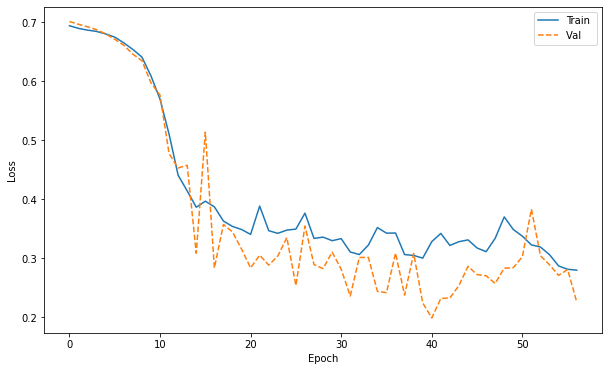

In [47]:
# Loss plot
plot_loss(history)

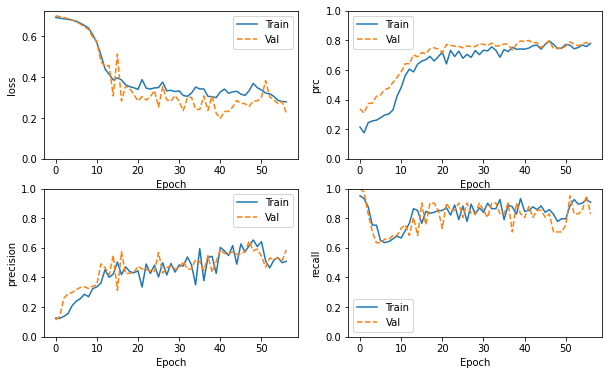

In [48]:
# Metric plot
plot_metrics(history)

<font size = 4><b> Evaluate Model

In [41]:
# Predict for train and test data using trained model
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

(True Negatives):  166
(False Positives):  12
(False Negatives):  1
(True Positives):  21
Total :  22


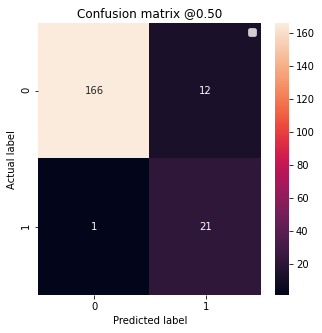

In [51]:
# Plot Confusion Matrix
plot_cm(y_test, test_predictions)

In [50]:
# Evaluate the model and output the various metrics
results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.18149976432323456
tp :  21.0
fp :  12.0
tn :  166.0
fn :  1.0
accuracy :  0.9350000023841858
precision :  0.6363636255264282
recall :  0.9545454382896423
auc :  0.9802093505859375
prc :  0.8792988061904907



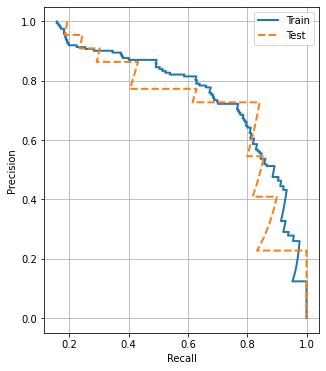

In [45]:
# Plot Precision-recall curve
plot_prc("Train", y_train, train_predictions)
plot_prc("Test", y_test, test_predictions, linestyle='--')